<h1 align='center'><b><font color='indianred'></p>Spam Detection</b></h1>




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/NLP/Lecture 2/Python_scripts')


Mounted at /content/drive


In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_test_smaller, y_test_pred))

In [ ]:
pip install pyspellchecker -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.3 MB/s eta 0:00:00


In [ ]:

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [ ]:
pip install xgboost -qq

In [ ]:
import custom_preprocessor_mod as cp
from featurizer import ManualFeatures
from plot_learning_curve import plot_learning_curve

In [ ]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/NLP/spam.csv'

In [ ]:
import chardet
with open(file_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7272080023536335, 'language': ''}

In [ ]:
spam_df = pd.read_csv(file_path,encoding='Windows-1252')
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
spam_df.rename(columns = {'v1':'label','v2':'message'}, inplace = True)
spam_df.columns

Index(['label', 'message', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
ham_count = spam_df['label'].value_counts()['ham']
total_count = spam_df.shape[0]
ham_percentage = (ham_count/total_count) * 100
print(f"The percentage of ham in the dataset is {round(ham_percentage,2)}")

The percentage of ham in the dataset is 86.59


In [ ]:
spam_count = spam_df['label'].value_counts()['spam']
total_count = spam_df.shape[0]
spam_percentage = (spam_count/total_count) * 100
print(f"The percentage of spam in the dataset is {round(spam_percentage,2)}")

The percentage of spam in the dataset is 13.41


Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model

In [ ]:
spam_df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1, inplace=True)

In [ ]:
smaller_df = spam_df.sample(frac=0.2, replace=True, random_state=1)

In [ ]:
train_smaller = smaller_df.sample(frac=0.7,replace=True,random_state=1)

In [ ]:
train_smaller['label'].value_counts()

ham     695
spam     85
Name: label, dtype: int64

In [ ]:
test_smaller = smaller_df.drop(train_smaller.index)
test_smaller['label'].value_counts()

ham     437
spam     62
Name: label, dtype: int64

Metric for evaluating the model

F1 score is an ideal metric for evaluating a imbalanced classifier model. F1 score is able to do this because it is calculated as the harmonic mean of both precision and recall of the minority positive class

Classification Pipelines

In [ ]:
train_smaller['label'] = train_smaller['label'].apply(lambda x: 0 if x == 'ham' else 1)
test_smaller['label'] = test_smaller['label'].apply(lambda x: 0 if x == 'ham' else 1)

In [ ]:
X_train_smaller = train_smaller['message'].values
X_test_smaller = test_smaller['message'].values
y_train_smaller = train_smaller['label'].values
y_test_smaller = test_smaller['label'].values

In [ ]:
X_train_cleaned = cp.SpacyPreprocessor(
    model='en_core_web_sm').transform(X_train_smaller)
file_X_train_cleaned_sparse_embed = '/content/drive/MyDrive/NLP/Lecture 2/x_train_cleaned_sparse_embed.pkl'
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP/Lecture 2/x_train_cleaned_sparse_embed.pkl']

In [ ]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_test_smaller)
X_test_features = featurizer.ManualFeatures(spacy_model='en_core_web_sm').fit_transform(X_test_cleaned)
file_X_test_cleaned_sparse_embed = '/content/drive/MyDrive/NLP/Lecture 2/x_test_cleaned_sparse_embed.pkl'
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP/Lecture 2/x_test_cleaned_sparse_embed.pkl']

In [ ]:
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', LogisticRegression(max_iter=10000)),])

In [ ]:
param_grid_classifier_1 = {'vectorizer__max_features': [1000, 2000, 5000],
                           'classifier__C': [1, 10, 100,]
                           }

grid_classifier_1 = GridSearchCV(
    estimator=classifier_1, param_grid=param_grid_classifier_1, cv=5)

In [ ]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train_smaller)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [1, 10, 100],
                         'vectorizer__max_features': [1000, 2000, 5000]})

In [ ]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__C': 100, 'vectorizer__max_features': 1000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])


In [ ]:
file_best_estimator_pipeline1_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline1_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_1.best_estimator_,
            file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)


['/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline1_round1_complete_grid.pkl']

In [ ]:
best_estimator_pipeline1_round1 = joblib.load(
    file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(
    file_complete_grid_pipeline1_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

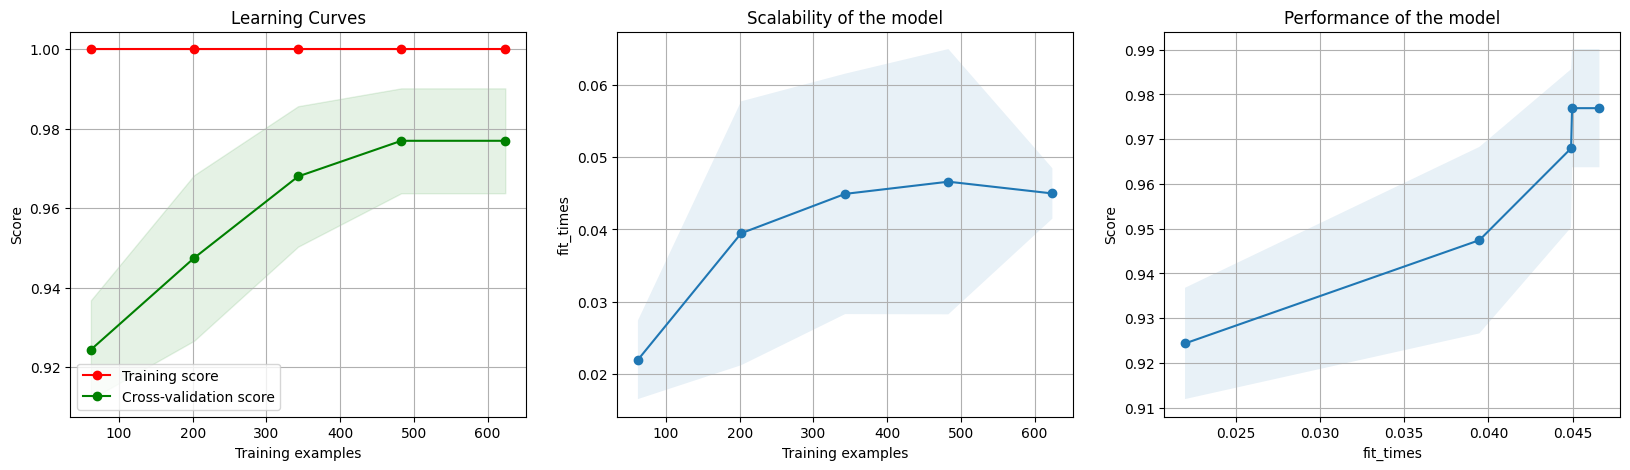

In [ ]:
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train_smaller, n_jobs=-1)

Evaluate model on test dataset

In [ ]:
def final_pipeline(text):
    cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    # cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(
        file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [ ]:
y_test_pred = final_pipeline(X_test_smaller)

In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test_smaller, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       437
           1       0.98      0.74      0.84        62

    accuracy                           0.97       499
   macro avg       0.97      0.87      0.91       499
weighted avg       0.97      0.97      0.96       499



In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_test_smaller, y_test_pred))

0.8440366972477064


Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline

In [ ]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
X_train_features, feature_names = featurizer.fit_transform(X_train_smaller)

/content/drive/MyDrive/NLP/Lecture 2/Python_scripts/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
X_train_features[0:3]

array([[ 13.        ,  60.        ,  48.        ,   3.42857143,
          0.        ,   0.        ,   0.        ,   1.        ,
          2.        ,   2.        ,   2.        ],
       [ 11.        ,  48.        ,  38.        ,   3.16666667,
          0.        ,   0.        ,   0.        ,   3.        ,
          1.        ,   2.        ,   0.        ],
       [ 34.        , 182.        , 149.        ,   4.25714286,
          0.        ,   0.        ,   2.        ,   9.        ,
          2.        ,   5.        ,   4.        ]])

In [ ]:
from spellchecker import SpellChecker
# function to identify the number of misspelled words
def misspelled_words(cleaned_text):
  misspelled_count = []
  for message in cleaned_text:
    word_list = message.split()
    spell = SpellChecker()
    misspelled = len(list(spell.unknown(word_list)))
    misspelled_count.append(misspelled)
  return np.array(misspelled_count).reshape(-1, 1)

In [ ]:
incorrect_word_count = misspelled_words(X_train_cleaned)


In [ ]:

incorrect_word_count[0:3]

array([[0],
       [1],
       [0]])

In [ ]:
X_train_addfeatures = np.append(X_train_features, incorrect_word_count, axis=1)

In [ ]:
X_train_addfeatures

array([[ 13.,  60.,  48., ...,   2.,   2.,   0.],
       [ 11.,  48.,  38., ...,   2.,   0.,   1.],
       [ 34., 182., 149., ...,   5.,   4.,   0.],
       ...,
       [  5.,  19.,  15., ...,   2.,   0.,   1.],
       [ 32., 143., 112., ...,   9.,   0.,   3.],
       [ 14.,  66.,  53., ...,   3.,   1.,   2.]])

In [ ]:
feature_names.append('mispelled_words')

In [ ]:
from xgboost import XGBClassifier

Create Pipeline


In [ ]:
classifier_2 = XGBClassifier()


In [ ]:
param_grid_classifier_2 = {'scale_pos_weight': [70, 80, 90, 99]}

In [ ]:
grid_classifier_2 = GridSearchCV(estimator=classifier_2,
                                 param_grid=param_grid_classifier_2,
                                 cv=3)

In [ ]:
grid_classifier_2.fit(X_train_addfeatures, y_train_smaller)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'scale_pos_weight': [70, 80, 90, 99]})

In [ ]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'scale_pos_weight': 80}

Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [ ]:
file_best_estimator_pipeline2_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline2_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_2.best_estimator_,
            file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)

['/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline2_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(
    file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(
    file_complete_grid_pipeline2_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

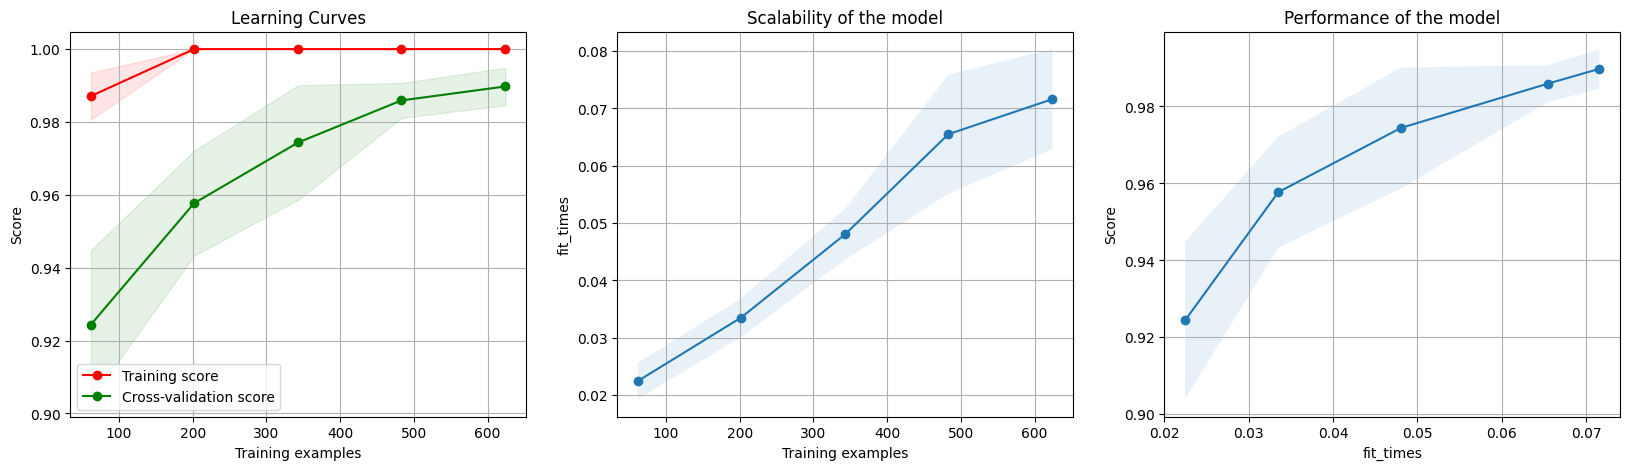

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_addfeatures, y_train_smaller, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline2_round1.score(X_train_addfeatures, y_train_smaller))

# let's check the cross validation score
print(complete_grid_pipeline2_round1.best_score_)

1.0
0.9846153846153847


Evaluation on Test data

In [ ]:
# Final Pipeline
def final_pipeline(text):
    features, feature_names = featurizer.fit_transform(text)
    incorrect_word_count = misspelled_words(text)
    features = np.append(features, incorrect_word_count, axis=1)
    best_estimator_pipeline2_round1 = joblib.load(
        file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test_smaller)

In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test_smaller, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.97      0.98       437
           1       0.83      0.92      0.87        62

    accuracy                           0.97       499
   macro avg       0.91      0.95      0.93       499
weighted avg       0.97      0.97      0.97       499



In [ ]:
print(f1_score(y_test_smaller, y_test_pred))

0.8702290076335878


Pipeline 3: Combine Manual Features and TfID vectors

In [ ]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [ ]:
feature_names.append('mispelled_words')

In [ ]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_addfeatures, columns=feature_names)), axis=1)

In [ ]:
X_train_final = X_train_final.drop('mispelled_words',axis=1)

In [ ]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,mispelled_words
0,soon real thing princess wet,13.0,60.0,48.0,3.428571,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0
1,s staff take class,11.0,48.0,38.0,3.166667,0.0,0.0,0.0,3.0,1.0,2.0,0.0,1.0
2,pure hearted person wonderful smile make enemy...,34.0,182.0,149.0,4.257143,0.0,0.0,2.0,9.0,2.0,5.0,4.0,0.0
3,ok tomorrow,8.0,32.0,25.0,2.777778,0.0,0.0,1.0,2.0,1.0,3.0,1.0,0.0
4,wait sir,7.0,30.0,24.0,3.000000,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0


In [ ]:
X_train_final.isnull().sum()

cleaned_text                 0
count_words                  0
count_characters             0
count_characters_no_space    0
avg_word_length              0
count_digits                 0
count_numbers                0
noun_count                   0
aux_count                    0
verb_count                   0
adj_count                    0
ner                          0
mispelled_words              0
dtype: int64

In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               780 non-null    object 
 1   count_words                499 non-null    float64
 2   count_characters           499 non-null    float64
 3   count_characters_no_space  499 non-null    float64
 4   avg_word_length            499 non-null    float64
 5   count_digits               499 non-null    float64
 6   count_numbers              499 non-null    float64
 7   noun_count                 499 non-null    float64
 8   aux_count                  499 non-null    float64
 9   verb_count                 499 non-null    float64
 10  adj_count                  499 non-null    float64
 11  ner                        499 non-null    float64
 12  mispelled_words            499 non-null    float64
dtypes: float64(12), object(1)
memory usage: 79.3+ KB


In [ ]:
subset = X_train_final[0:10]

In [ ]:
subset.shape

(10, 13)

In [ ]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [ ]:
sparse_features.fit_transform(subset.iloc[:, 1:])

<10x12 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.fit_transform(subset.iloc[:, 0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [ ]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [ ]:
test = combined_features.fit_transform(subset)

In [ ]:
test

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   6.        ,  20.        ,  15.        ,
          2.14285714,   0.        ,   0.        ,   0.        ,
          4.        ,   0.        ,   1.        ,   0.        ,
          4.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,  10.        ,  45.        ,  32.        ,
          2.90909091,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   2.        ,   0.        ,
          2.        ],
       [  0.70710678,   0.        ,   0.        ,   0.70710678,
          0.        ,  14.        ,  60.        ,  47.        ,
          3.13333333,   0.        ,   0.        ,   1.        ,
          7.        ,   2.        ,   1.        ,   0.        ,
          4.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  18.        , 135.        , 118.        ,
          6.21052632,  17.        ,

In [ ]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                         ])

In [ ]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                           'classifier__C': [0.1, 1, 10]
                           }

In [ ]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=3)

In [ ]:
# Fit the model on training data
grid_classifier_3.fit(X_train_final, y_train_smaller)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]})

In [ ]:
print(
    "Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


In [ ]:
file_best_estimator_pipeline3_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = '/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline3_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_3.best_estimator_,
            file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

['/content/drive/MyDrive/NLP/Lecture 2/model_folder/pipeline3_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline3_round1 = joblib.load(
    file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(
    file_complete_grid_pipeline3_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

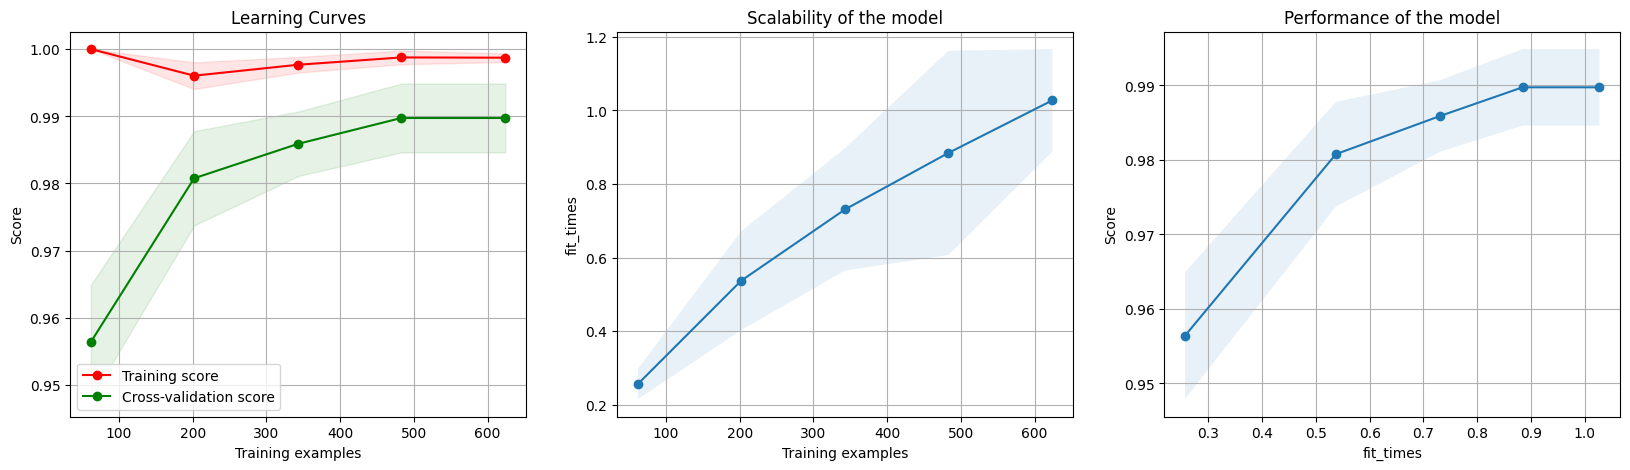

In [ ]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train_smaller, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train_smaller))

# let's check the cross validation score
print(complete_grid_pipeline3_round1.best_score_)

0.9987179487179487
0.985897435897436


Evaluating model on Test Data

In [ ]:
# Final Pipeline
def final_pipeline(text):
    cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    # cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)

    X_features, feature_names = featurizer.fit_transform(text)
    incorrect_word_count = misspelled_words(text)
    X_features = np.append(X_features, incorrect_word_count, axis=1)
    feature_names.append('mispelled_words')
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(
        file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test_smaller)

/content/drive/MyDrive/NLP/Lecture 2/Python_scripts/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
print('\nTest set classification report:\n\n',
      classification_report(y_test_smaller, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       437
           1       0.95      0.90      0.93        62

    accuracy                           0.98       499
   macro avg       0.97      0.95      0.96       499
weighted avg       0.98      0.98      0.98       499



Based on the 3 pipelines. I would choose the third pipeline with Sparse Embeddings (TF-IDF) + Feature Engineering. This pipeline has thehighest f1 score of 0.93. This pipeline obtained a f1 score 0.93 with a Logistic Regression algorithm, which is one one of the simplest classification algorithm.